In [2]:
import os
path_notebook = os.getcwd()
os.chdir("..")
path = os.getcwd()
print("Path of MFI folder:", path)


from pyMFI import MFI
import scipy
from pyMFI import MFI1D
from pyMFI import run_plumed

import numpy as np
import pickle
import matplotlib.pyplot as plt
import glob
import sys

#Analytical surface
x = np.linspace(-2, 2, 201)
y = 7*x**4-23*x**2
y = y - min(y)

# os.chdir("./1D_double_well")

Path of MFI folder: /home/ucecabj/Desktop/pyMFI_git


## Run WT-MetaD simulation

In [41]:
#change working directory to data_files
os.chdir(path + "/DATA_examples/1D_double_well/")
#remove previous results
os.system("rm analysis.*")
os.system("rm fes.dat")
os.system("rm bck.*")

simulation_steps = 2000000
run_plumed.run_langevin1D_plumed_fes(length = simulation_steps, initial_position=1.7, sigma=0.1, height=1, biasfactor=10, fes_stride = int(simulation_steps/100))

os.system("rm bck.*")

rm: cannot remove 'bck.*': No such file or directory


Running simulation
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.5 (git: Unknown) compiled on Dec 13 2022 at 12:42:50
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/ulocal/lib/plumed
PLUMED: For installed feature, see /usr/ulocal/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: pesmd
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 2
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action DISTANCE
PLUMED:   with label p
PLUMED:   between atoms 1 2
PLUMED:   using periodic boundary conditions
PLUMED:   added component to this action:  p.x 
PLUMED:   added component to this action:  p.y 
PLUMED:   added component to this action:  p.z 
PLUMED:   WARNING: components will not have the proper periodicity - see manual
PLUMED: Action MATHEVAL
PLUMED:   with label ff
P

0

## Analyse with MFI

-1
10.0%   OFE = 32.0446
20.0%   OFE = 31.3813
30.0%   OFE = 30.9309
40.0%   OFE = 30.7127
50.0%   OFE = 30.5566
60.0%   OFE = 30.407
70.0%   OFE = 30.38
80.0%   OFE = 30.2887
90.0%   OFE = 30.288
100.0%   OFE = 30.2862
AAD =  0.08961502431426965


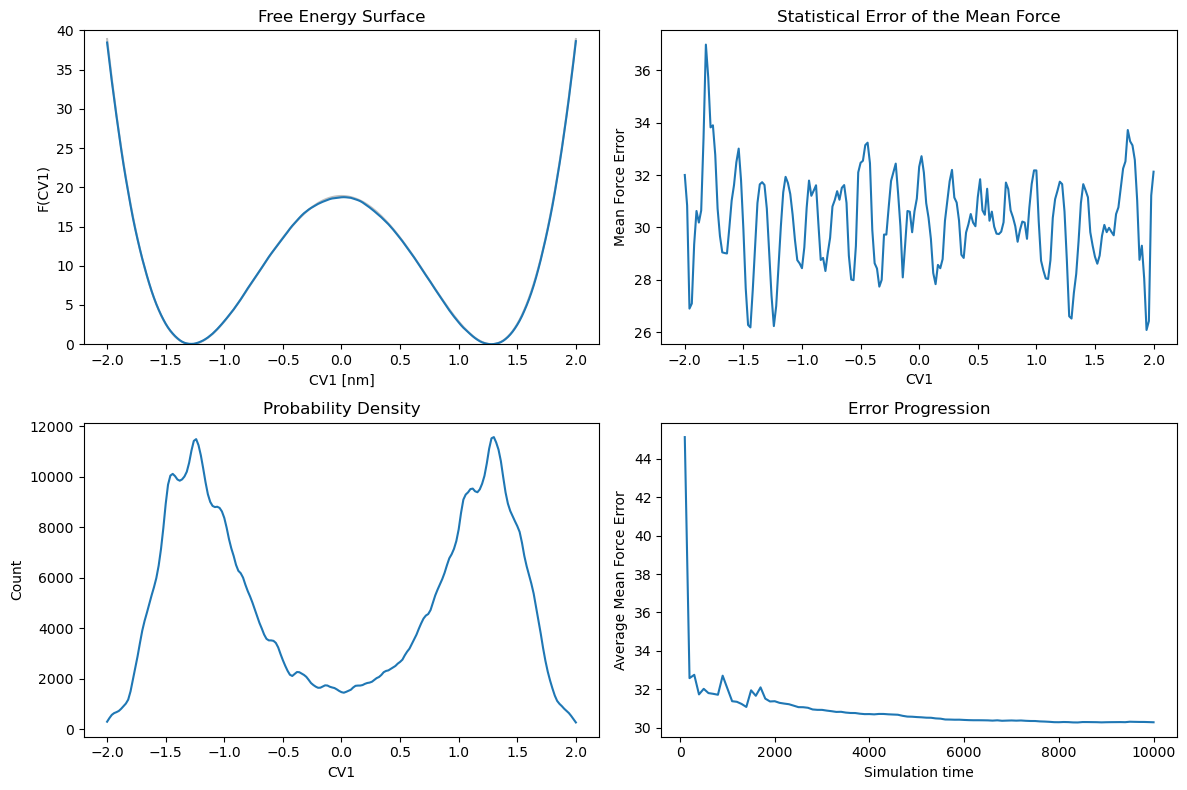

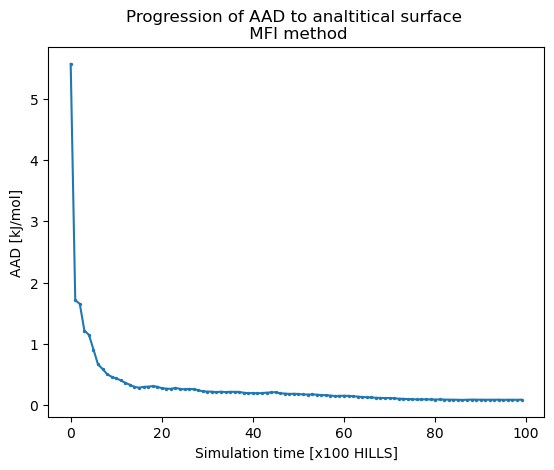

In [65]:
#change working directory to data_files
os.chdir(path + "/DATA_examples/1D_double_well/")

#Read the HILLS file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")

#Read the Colvar File
position = MFI1D.load_position(position_name="position")

#Compute the time-independent mean force
[X, Ftot_den, Ftot, FES, ofv, ofe, cutoff, ofv_history, ofe_history, time_history, intermediate_fes_list, intermediate_time_list] = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.02, kT = 1, min_grid=-2, 
                                                         max_grid=2, nbins=201, log_pace=10, error_pace=100, WellTempered=1, intermediate_fes_number=100)

#calculate error
AD = abs(FES - y)
AAD = np.sum(AD) / len(AD)
print("AAD = ", AAD)


# Plot Recap
lim=40
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(x, y, c="grey", alpha=0.5)
axs[0, 0].plot(X, FES)
axs[0, 0].set_ylim([0, lim])
axs[0, 0].set_ylabel('F(CV1)')
axs[0, 0].set_xlabel('CV1 [nm]')
axs[0, 0].set_title('Free Energy Surface')

axs[0, 1].plot(X, ofe);
axs[0, 1].set_ylabel('Mean Force Error')
axs[0, 1].set_xlabel('CV1')
axs[0, 1].set_title('Statistical Error of the Mean Force')

axs[1, 0].plot(X, Ftot_den);
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_xlabel('CV1')
axs[1, 0].set_title('Probability Density')

axs[1, 1].plot(time_history, ofe_history);
axs[1, 1].set_ylabel('Average Mean Force Error')
axs[1, 1].set_xlabel('Simulation time')
axs[1, 1].set_title('Error Progression')
plt.tight_layout()
plt.show()


AAD_progression = []
for i in range(len(intermediate_fes_list)):
    AAD_progression.append(sum(abs(y - intermediate_fes_list[i]))/len(y))
   
plt.plot(range(len(AAD_progression)), AAD_progression)
plt.scatter(range(len(AAD_progression)), AAD_progression, s=2)
plt.xlabel("Simulation time [x100 HILLS]"); plt.ylabel("AAD [kJ/mol]"); plt.title("Progression of AAD to analtitical surface \n MFI method")
plt.show()

error_progression_MFI = AAD_progression


## Analyse with REWEIGHT_METAD

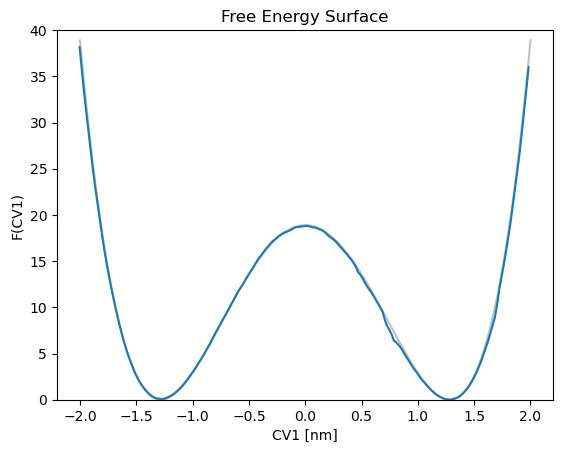

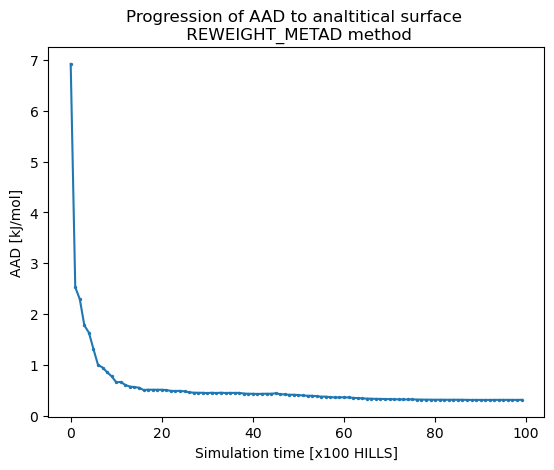

In [64]:

#change working directory to data_files
os.chdir(path + "/DATA_examples/1D_double_well/")
error_progression = []

for filen in sorted(glob.glob( "analysis.*." + "fes.dat" ), key=os.path.getmtime) :
    data = np.loadtxt( filen )
    grid_data = data[:,0][50:251]
    fes_data = data[:,1][50:251]
    fes_data = fes_data - min(fes_data)
    fes_data = np.where(fes_data < 10E4, fes_data, np.max(y))
    # plt.plot(grid_data, fes_data)
    # plt.plot(x,y)
    # plt.show()  
    diff = abs(y - fes_data)
    error_progression.append((sum(diff)/len(diff)))
    
 
         
for filen in glob.glob("fes.dat"):
    data = np.loadtxt( filen )
    grid_data = data[:,0][50:251]
    fes_data = data[:,1][50:251]
    fes_data = fes_data - min(fes_data)
    error_progression.append((sum(abs(y - fes_data))/len(y)))
    
plt.plot(x,y, c="grey", alpha=0.5)
plt.plot(grid_data, fes_data)
plt.ylim([0, 40])
plt.ylabel('F(CV1)')
plt.xlabel('CV1 [nm]')
plt.title('Free Energy Surface')
plt.show() 
    
plt.plot(range(len(error_progression)), error_progression)
plt.scatter(range(len(error_progression)), error_progression, s=2)
plt.xlabel("Simulation time [x100 HILLS]"); plt.ylabel("AAD [kJ/mol]"); plt.title("Progression of AAD to analtitical surface \n REWEIGHT_METAD method")
plt.show()

error_progression_wt_metad = error_progression


## Analyse with sum_hills

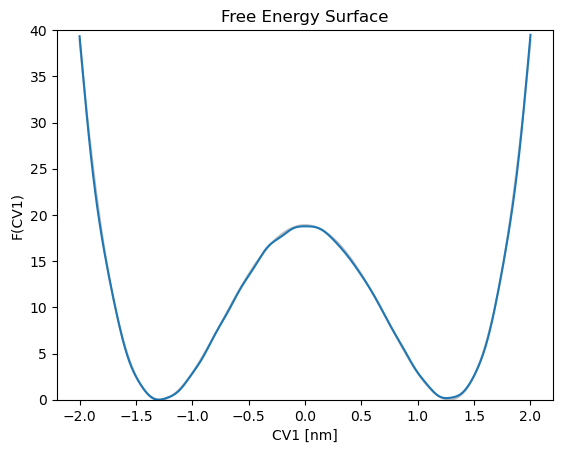

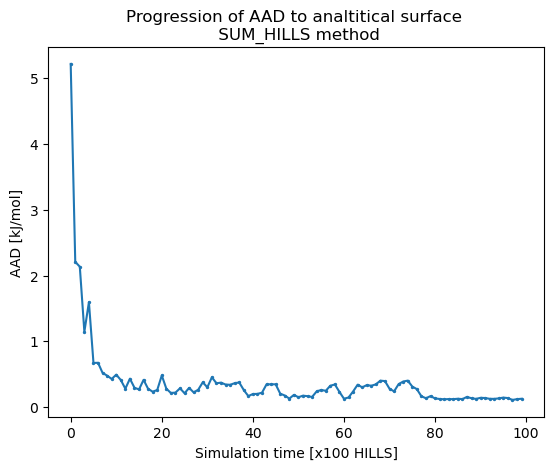

rm: cannot remove 'bck.*': No such file or directory


In [86]:
#change working directory to data_files
os.chdir(path + "/DATA_examples/1D_double_well/sum_hills")
os.system("rm fes_*")
os.system("rm HILLS")
os.system("rm position")
os.system("cp ../HILLS HILLS")
os.system("cp ../position position")

os.system("plumed sum_hills --hills HILLS --stride 201 --min -2.0 --max 2.0 --bin 200 > /dev/null")

error_progression = []

for i in range(100):
    for filen in glob.glob( "fes_" + str(i) + ".dat" ):
        data = np.loadtxt( filen )
        grid_data = data[:,0]
        fes_data = data[:,1]
        fes_data = fes_data - min(fes_data)
        fes_data = np.where(fes_data < 10E4, fes_data, 40)
        diff = abs(y - fes_data)
        error_progression.append((sum(diff)/len(diff)))    
        # plt.plot(x,y, c="grey")
        # plt.plot(grid_data, fes_data, )
        # plt.show() 

plt.plot(x,y, c="grey", alpha=0.5)
plt.plot(grid_data, fes_data)
plt.ylim([0, 40])
plt.ylabel('F(CV1)')
plt.xlabel('CV1 [nm]')
plt.title('Free Energy Surface')
plt.show()     


plt.plot(range(len(error_progression)), error_progression)
plt.scatter(range(len(error_progression)), error_progression, s=2)
plt.xlabel("Simulation time [x100 HILLS]"); plt.ylabel("AAD [kJ/mol]"); plt.title("Progression of AAD to analtitical surface \n SUM_HILLS method")
plt.show()

error_progression_wt_sumhills = error_progression

os.system("rm bck.*")
os.chdir("..")


## Run (non-WT) MetaD simulation

In [45]:
#change working directory to data_files
os.chdir(path + "/DATA_examples/1D_double_well/non_WT")
os.system("rm analysis.*")
os.system("rm fes.dat")
os.system("rm bck.*")

simulation_steps = 2000000
run_plumed.run_langevin1D_plumed_fes(length = simulation_steps, initial_position=-1.7, sigma=0.1, height=1, biasfactor=-1, fes_stride = int(simulation_steps/100), grid_min=-4, grid_max=4, grid_bin=400)
os.system("rm bck.*")

rm: cannot remove 'bck.*': No such file or directory


Running simulation
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.5 (git: Unknown) compiled on Dec 13 2022 at 12:42:50
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/ulocal/lib/plumed
PLUMED: For installed feature, see /usr/ulocal/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: pesmd
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 2
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action DISTANCE
PLUMED:   with label p
PLUMED:   between atoms 1 2
PLUMED:   using periodic boundary conditions
PLUMED:   added component to this action:  p.x 
PLUMED:   added component to this action:  p.y 
PLUMED:   added component to this action:  p.z 
PLUMED:   WARNING: components will not have the proper periodicity - see manual
PLUMED: Action MATHEVAL
PLUMED:   with label ff
P

0

## Analyse with MFI

-1
10.0%   OFE = 37.3696
20.0%   OFE = 37.666
30.0%   OFE = 37.7921
40.0%   OFE = 37.9146
50.0%   OFE = 38.0737
60.0%   OFE = 38.0945
70.0%   OFE = 38.0998
80.0%   OFE = 38.1364
90.0%   OFE = 38.1981
100.0%   OFE = 38.2212
AAD =  0.18770432000030932


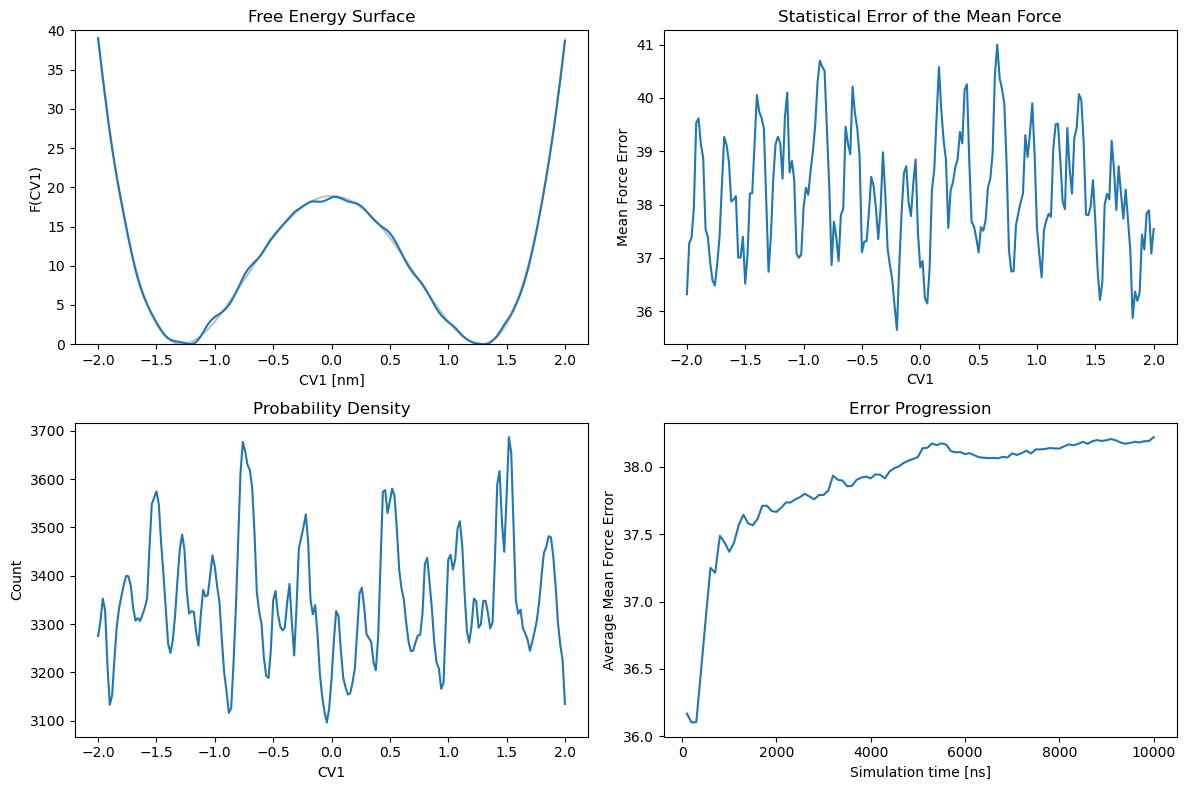

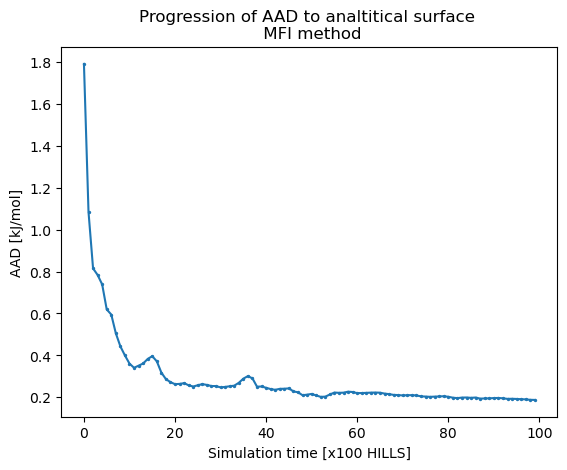

In [62]:
#change working directory to data_files
os.chdir(path + "/DATA_examples/1D_double_well/non_WT")

#Read the HILLS file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")

#Read the Colvar File
position = MFI1D.load_position(position_name="position")

#Compute the time-independent mean force
[X, Ftot_den, Ftot, FES, ofv, ofe, cutoff, ofv_history, ofe_history, time_history, intermediate_fes_list, intermediate_time_list] = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.02, kT = 1, min_grid=-2, max_grid=2, nbins=201, log_pace=10, error_pace=100, WellTempered=0, intermediate_fes_number=100)

#calculate error
AD = abs(FES - y)
AAD = np.sum(AD) / len(AD)
print("AAD = ", AAD)

error_progression_MFI_non_WT = []
for i in range(len(intermediate_fes_list)):
    error_progression_MFI_non_WT.append(sum(abs(y - intermediate_fes_list[i]))/len(y))


# Plot Recap
lim=40
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(x, y, c="grey", alpha=0.5)
axs[0, 0].plot(X, FES)
axs[0, 0].set_ylim([0, lim])
axs[0, 0].set_ylabel('F(CV1)')
axs[0, 0].set_xlabel('CV1 [nm]')
axs[0, 0].set_title('Free Energy Surface')

axs[0, 1].plot(X, ofe);
axs[0, 1].set_ylabel('Mean Force Error')
axs[0, 1].set_xlabel('CV1')
axs[0, 1].set_title('Statistical Error of the Mean Force')

axs[1, 0].plot(X, Ftot_den);
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_xlabel('CV1')
axs[1, 0].set_title('Probability Density')

axs[1, 1].plot(time_history, ofe_history);
axs[1, 1].set_ylabel('Average Mean Force Error')
axs[1, 1].set_xlabel('Simulation time [ns]')
axs[1, 1].set_title('Error Progression')
plt.tight_layout()
plt.show()


plt.plot(range(len(error_progression_MFI_non_WT)), error_progression_MFI_non_WT)
plt.scatter(range(len(error_progression_MFI_non_WT)), error_progression_MFI_non_WT, s=2)
plt.xlabel("Simulation time [x100 HILLS]"); plt.ylabel("AAD [kJ/mol]"); plt.title("Progression of AAD to analtitical surface \n MFI method")
plt.show()

os.chdir("..")

## Analyse with Reweight MetaD

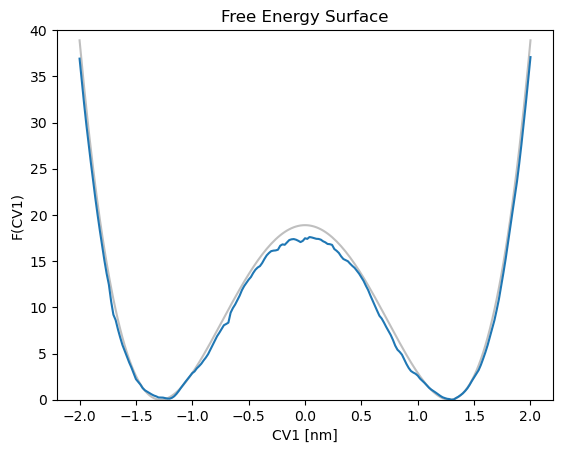

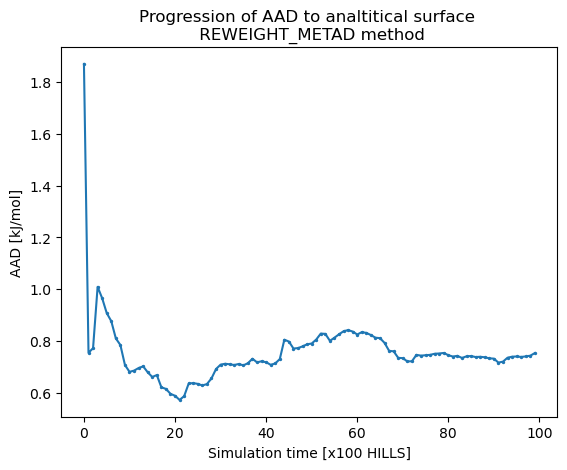

In [61]:
#change working directory to data_files
os.chdir(path + "/DATA_examples/1D_double_well/non_WT")

error_progression = []

for filen in sorted(glob.glob( "analysis.*." + "fes.dat" ), key=os.path.getmtime) :
    data = np.loadtxt( filen ) 
    grid_data = data[:,0][100:301]
    fes_data = data[:,1][100:301]
    fes_data = fes_data - min(fes_data)
    fes_data = np.where(fes_data < 10E4, fes_data, np.max(y))
    # plt.plot(grid_data, fes_data)
    # plt.plot(x,y)
    # plt.show()  
    diff = abs(y - fes_data)
    error_progression.append((sum(diff)/len(diff)))
    
for filen in glob.glob("fes.dat"):
    data = np.loadtxt( filen )
    grid_data = data[:,0][100:301]
    fes_data = data[:,1][100:301]
    fes_data = fes_data - min(fes_data)
    error_progression.append((sum(abs(y - fes_data))/len(y)))
    
plt.plot(x,y, c="grey", alpha=0.5)
plt.plot(grid_data, fes_data)
plt.ylim([0, 40])
plt.ylabel('F(CV1)')
plt.xlabel('CV1 [nm]')
plt.title('Free Energy Surface')
plt.show() 
    
plt.plot(range(len(error_progression)), error_progression)
plt.scatter(range(len(error_progression)), error_progression, s=2)
plt.xlabel("Simulation time [x100 HILLS]"); plt.ylabel("AAD [kJ/mol]"); plt.title("Progression of AAD to analtitical surface \n REWEIGHT_METAD method")
plt.show()

error_progression_nonWT_metad = error_progression

os.chdir("..")

## Analyse with SUM_HILLS

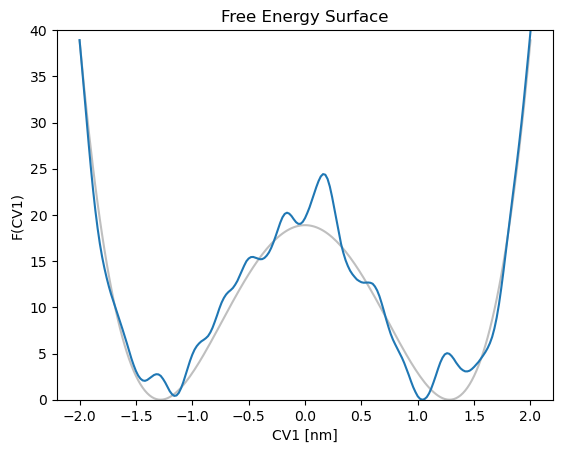

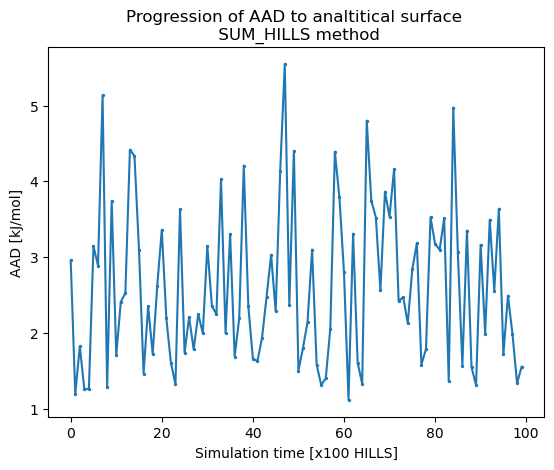

rm: cannot remove 'bck.*': No such file or directory


In [84]:
#change working directory to data_files
os.chdir(path + "/DATA_examples/1D_double_well/non_WT/sum_hills") 
os.system("rm fes_*")
os.system("rm HILLS")
os.system("rm position")
os.system("cp ../HILLS HILLS")
os.system("cp ../position position")

os.system("plumed sum_hills --hills HILLS --stride 201 --min -2.0 --max 2.0 --bin 200 > /dev/null")   #pay attention to stride when changing simulation length.

error_progression = []

for i in range(100):
    for filen in glob.glob( "fes_" + str(i) + ".dat" ):
        data = np.loadtxt( filen )
        grid_data = data[:,0]
        fes_data = data[:,1]
        fes_data = fes_data - min(fes_data)
        fes_data = np.where(fes_data < 10E4, fes_data, 40)
        diff = abs(y - fes_data)
        error_progression.append((sum(diff)/len(diff)))    
        # plt.plot(x,y, c="grey")
        # plt.plot(grid_data, fes_data, )
        # plt.show() 

plt.plot(x,y, c="grey", alpha=0.5)
plt.plot(grid_data, fes_data)
plt.ylim([0, 40])
plt.ylabel('F(CV1)')
plt.xlabel('CV1 [nm]')
plt.title('Free Energy Surface')
plt.show()     


plt.plot(range(len(error_progression)), error_progression)
plt.scatter(range(len(error_progression)), error_progression, s=2)
plt.xlabel("Simulation time [x100 HILLS]"); plt.ylabel("AAD [kJ/mol]"); plt.title("Progression of AAD to analtitical surface \n SUM_HILLS method")
plt.show()

error_progression_nonwt_sumhills = error_progression

os.system("rm bck.*")
os.chdir("..")

## Plot all

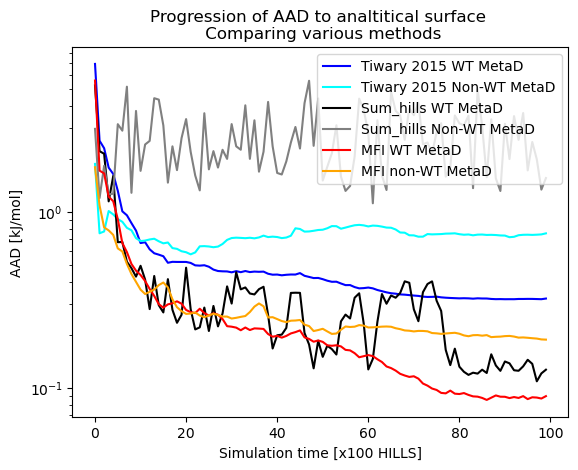

In [87]:
plt.plot(range(len(error_progression_wt_metad)), error_progression_wt_metad, label="Tiwary 2015 WT MetaD", color="blue")
plt.plot(range(len(error_progression_nonWT_metad)), error_progression_nonWT_metad, label="Tiwary 2015 Non-WT MetaD", color="cyan")

plt.plot(range(len(error_progression_wt_sumhills)), error_progression_wt_sumhills, label="Sum_hills WT MetaD", color="black")
plt.plot(range(len(error_progression_nonwt_sumhills)), error_progression_nonwt_sumhills, label="Sum_hills Non-WT MetaD", color="grey")

plt.plot(range(len(error_progression_MFI)), error_progression_MFI, label="MFI WT MetaD", color="red")
plt.plot(range(len(error_progression_MFI_non_WT)), error_progression_MFI_non_WT, label="MFI non-WT MetaD", color="orange")
# plt.plot(range(len(error_progression_MFI)), error_progression_MFI*np.power(range(len(error_progression_MFI)),0.5), label="MFI WT MetaD", color="red")

plt.legend()
plt.xlabel("Simulation time [x100 HILLS]")
plt.ylabel("AAD [kJ/mol]")
plt.title("Progression of AAD to analtitical surface \n Comparing various methods")
plt.yscale("log")

plt.show()

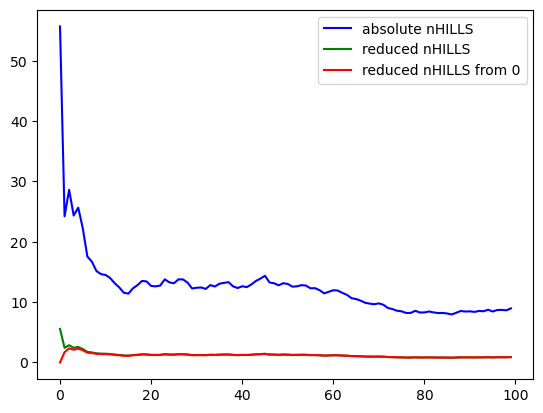

In [131]:
scalor = [np.sqrt((i+1)*100) for i in range(100)]
plt.plot(range(len(error_progression_MFI)), np.array(error_progression_MFI)*scalor, label="absolute nHILLS", color="blue")

scalor = [np.sqrt(i+1) for i in range(100)]
plt.plot(range(len(error_progression_MFI)), np.array(error_progression_MFI)*scalor, label="reduced nHILLS", color="green")

scalor = [np.sqrt(i) for i in range(100)]
plt.plot(range(len(error_progression_MFI)), error_progression_MFI*np.sqrt(range(len(error_progression_MFI))), label="reduced nHILLS from 0", color="red")

plt.legend()
plt.show()

In [ ]:
plt.plot(range(len(error_progression_wt_metad)), error_progression_wt_metad, label="Tiwary 2015 WT MetaD", color="blue")
plt.plot(range(len(error_progression_nonWT_metad)), error_progression_nonWT_metad, label="Tiwary 2015 Non-WT MetaD", color="cyan")

plt.plot(range(len(error_progression_wt_sumhills)), error_progression_wt_sumhills, label="Sum_hills WT MetaD", color="black")
plt.plot(range(len(error_progression_nonwt_sumhills)), error_progression_nonwt_sumhills, label="Sum_hills Non-WT MetaD", color="grey")

plt.plot(range(len(error_progression_MFI)), error_progression_MFI, label="MFI WT MetaD", color="red")
plt.plot(range(len(error_progression_MFI_non_WT)), error_progression_MFI_non_WT, label="MFI non-WT MetaD", color="orange")
# plt.plot(range(len(error_progression_MFI)), error_progression_MFI*np.sqrt(range(len(error_progression_MFI)),0.5), label="MFI WT MetaD", color="red")

plt.legend()
plt.xlabel("Simulation time [x100 HILLS]")
plt.ylabel("AAD [kJ/mol]")
plt.title("Progression of AAD to analtitical surface \n Comparing various methods")
plt.yscale("log")

plt.show()

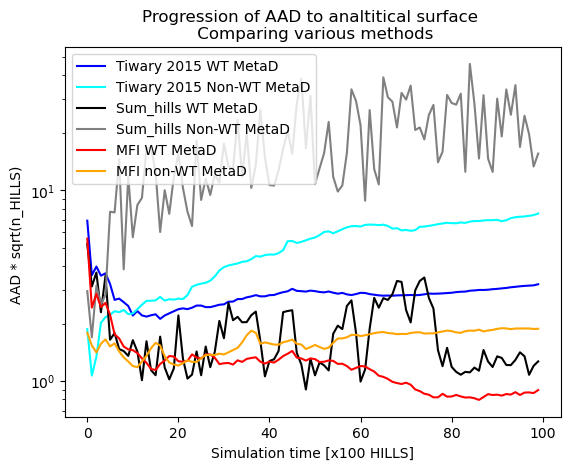

In [117]:
scalor = [np.sqrt((i+1)*1) for i in range(100)]


plt.plot(range(len(error_progression_wt_metad)), np.array(error_progression_wt_metad)*scalor, label="Tiwary 2015 WT MetaD", color="blue")
plt.plot(range(len(error_progression_nonWT_metad)), np.array(error_progression_nonWT_metad)*scalor, label="Tiwary 2015 Non-WT MetaD", color="cyan")

plt.plot(range(len(error_progression_wt_sumhills)), np.array(error_progression_wt_sumhills)*scalor, label="Sum_hills WT MetaD", color="black")
plt.plot(range(len(error_progression_nonwt_sumhills)), np.array(error_progression_nonwt_sumhills)*scalor, label="Sum_hills Non-WT MetaD", color="grey")

plt.plot(range(len(error_progression_MFI)), np.array(error_progression_MFI)*scalor, label="MFI WT MetaD", color="red")
plt.plot(range(len(error_progression_MFI_non_WT)), np.array(error_progression_MFI_non_WT)*scalor, label="MFI non-WT MetaD", color="orange")
# plt.plot(range(len(error_progression_MFI)), error_progression_MFI*np.sqrt(range(len(error_progression_MFI)),0.5), label="MFI WT MetaD", color="red")

plt.legend()
plt.xlabel("Simulation time [x100 HILLS]")
plt.ylabel("AAD * sqrt(n_HILLS) ")
plt.title("Progression of AAD to analtitical surface \n Comparing various methods")
plt.yscale("log")

plt.show()


In [ ]:
# results_path = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/results_plot"

# MFI.save_pkl([x, y, FES, ofe], "mfi_results.pkl")
# MFI.save_pkl([error_progression_wt_metad, error_progression_wt_sumhills, error_progression_MFI], "error_progression.pkl")

